In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.cuda
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import os
from joblib import dump, load
from PIL import Image
from tqdm.notebook import tqdm
from torch.nn.functional import relu
from torch.utils.data import DataLoader, Dataset
from SHG import SHG
from utils import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

In [2]:
""" PATHS """
# Bottleneck data path
DATA_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/data/"

# Ground truth heatmaps
HEATMAPS_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/train/heatmaps/"

# Path for model
MODEL_DIR = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/models/Mon_Apr_12_18-11-59_2021/epoch_46.pth"

# Path for mean rgb
average_rgb = np.loadtxt("./average_rgb.npy")

# Saving path
SAVING_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space/"

In [3]:
""" LOADING """
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_without_branches = SHG(num_hourglasses = 1, use_skip_connections = False).to(device)
model_with_branches = SHG(num_hourglasses = 1, use_skip_connections = True).to(device)

model_without_branches.load_state_dict(torch.load(MODEL_DIR))
model_with_branches.load_state_dict(torch.load(MODEL_DIR))

model_without_branches.eval()
model_with_branches.eval()

X, y, IDs = load_data(DATA_PATH, HEATMAPS_PATH)
X = np.array(X).reshape((len(X), X[0].shape[0]))

In [4]:
""" MED PROJEKTERING, CENTROID FØR PROJEKTERING """
# Har prøvet uden standardizering og det gav (næsten) de samme resultater
# Tror uden projektering giver samme mønster
# Centroid efter projektering giver (næsten) de samme resultater

' MED PROJEKTERING, CENTROID FØR PROJEKTERING '

In [5]:
""" Finding centroid of data """
X_mean = np.mean(StandardScaler().fit_transform(X), axis = 0)
dists = np.linalg.norm(StandardScaler().fit_transform(X) - X_mean, axis = 1)

centroid_X = X[np.argmin(dists)]
centroid_y = y[np.argmin(dists)]

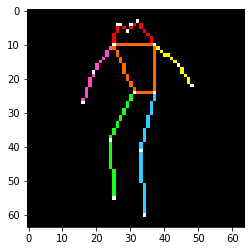

In [18]:
""" Visualizing centroid skeleton """
kp = turn_featuremaps_to_keypoints(centroid_y)
skeleton = draw_skeleton(kp)
centroid = skeleton
plt.imshow(skeleton)
plt.show()

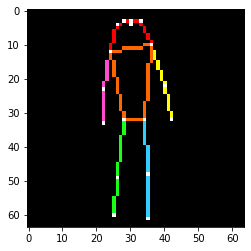

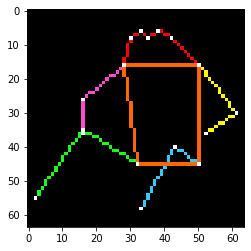

In [22]:
""" Exploring first component """
c = 5
PC = 1

scaler = StandardScaler().fit(X)
pca = PCA(n_components=PC).fit(scaler.transform(X))
X_1 = pca.transform(scaler.transform(X))
X_1_centroid = pca.transform(scaler.transform(centroid_X.reshape((1, -1)))) 
std = np.sqrt(pca.explained_variance_[PC - 1])

centroid_positive = X_1_centroid + c * std
centroid_negative = X_1_centroid - c * std

positive_dists = np.linalg.norm(X_1 - centroid_positive, axis = 1)
negative_dists = np.linalg.norm(X_1 - centroid_negative, axis = 1)

positive_closest_point = y[np.argmin(positive_dists)]
negative_closest_point = y[np.argmin(negative_dists)]

positive_kp = turn_featuremaps_to_keypoints(positive_closest_point)
negative_kp = turn_featuremaps_to_keypoints(negative_closest_point)

positive_skeleton = draw_skeleton(positive_kp)
negative_skeleton = draw_skeleton(negative_kp)

positive_PC_1 = positive_skeleton
plt.imshow(positive_skeleton)
plt.show()

negative_PC_1 = negative_skeleton
plt.imshow(negative_skeleton)
plt.show()

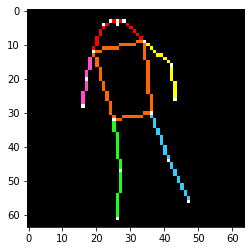

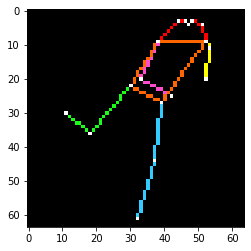

In [23]:
""" Exploring second component """
c = 5
PC = 2

scaler = StandardScaler().fit(X)
pca = PCA(n_components=PC).fit(scaler.transform(X))
X_2 = pca.transform(scaler.transform(X))
X_2_centroid = pca.transform(scaler.transform(centroid_X.reshape((1, -1)))) 
std = np.sqrt(pca.explained_variance_[PC - 1])

centroid_positive = X_2_centroid + c * std
centroid_negative = X_2_centroid - c * std

positive_dists = np.linalg.norm(X_2 - centroid_positive, axis = 1)
negative_dists = np.linalg.norm(X_2 - centroid_negative, axis = 1)

positive_closest_point = y[np.argmin(positive_dists)]
negative_closest_point = y[np.argmin(negative_dists)]

positive_kp = turn_featuremaps_to_keypoints(positive_closest_point)
negative_kp = turn_featuremaps_to_keypoints(negative_closest_point)

positive_skeleton = draw_skeleton(positive_kp)
negative_skeleton = draw_skeleton(negative_kp)

positive_PC_2 = positive_skeleton
plt.imshow(positive_skeleton)
plt.show()

negative_PC_2 = negative_skeleton
plt.imshow(negative_skeleton)
plt.show()

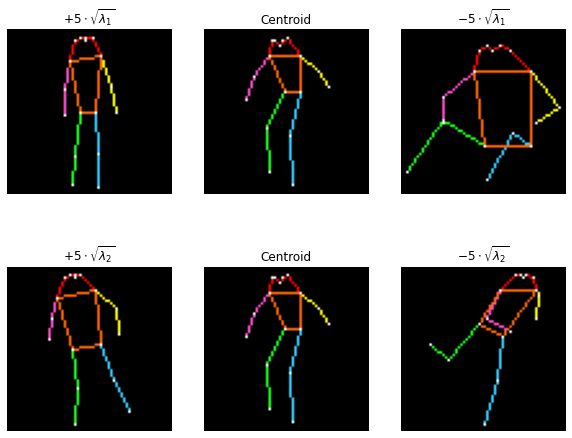

In [35]:
fig, axs = plt.subplots(2, 3, figsize = (10, 8))

axs[0, 0].imshow(positive_PC_1)
axs[0, 0].axis("off")
axs[0, 0].set_title("$+5 \cdot \sqrt{\lambda_1}$")

axs[0, 1].imshow(centroid)
axs[0, 1].axis("off")
axs[0, 1].set_title("Centroid")

axs[0, 2].imshow(negative_PC_1)
axs[0, 2].axis("off")
axs[0, 2].set_title("$-5 \cdot \sqrt{\lambda_1}$")

axs[1, 0].imshow(positive_PC_2)
axs[1, 0].axis("off")
axs[1, 0].set_title("$+5 \cdot \sqrt{\lambda_2}$")

axs[1, 1].imshow(centroid)
axs[1, 1].axis("off")
axs[1, 1].set_title("Centroid")

axs[1, 2].imshow(negative_PC_2)
axs[1, 2].axis("off")
axs[1, 2].set_title("$-5 \cdot \sqrt{\lambda_2}$")

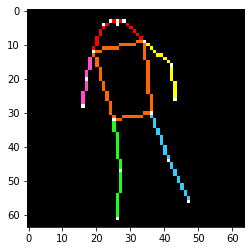

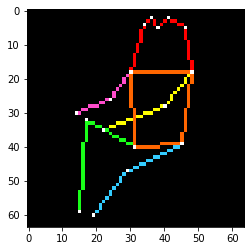

In [105]:
""" Exploring third component """
c = 5
PC = 3

scaler = StandardScaler().fit(X)
pca = PCA(n_components=PC).fit(scaler.transform(X))
X_2 = pca.transform(scaler.transform(X))
X_2_centroid = pca.transform(scaler.transform(centroid_X.reshape((1, -1)))) 
std = np.sqrt(pca.explained_variance_[PC - 1])

centroid_positive = X_2_centroid + c * std
centroid_negative = X_2_centroid - c * std

positive_dists = np.linalg.norm(X_2 - centroid_positive, axis = 1)
negative_dists = np.linalg.norm(X_2 - centroid_negative, axis = 1)

positive_closest_point = y[np.argmin(positive_dists)]
negative_closest_point = y[np.argmin(negative_dists)]

positive_kp = turn_featuremaps_to_keypoints(positive_closest_point)
negative_kp = turn_featuremaps_to_keypoints(negative_closest_point)

positive_skeleton = draw_skeleton(positive_kp)
negative_skeleton = draw_skeleton(negative_kp)

plt.imshow(positive_skeleton)
plt.show()

plt.imshow(negative_skeleton)
plt.show()

In [24]:
""" Shape analysis of clusters """
model = KMeans(n_clusters=2).fit(StandardScaler().fit_transform(X))

cluster_1 = X[model.labels_.astype("bool")]
cluster_2 = X[np.logical_not(model.labels_.astype("bool"))]

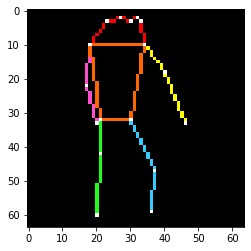

In [25]:
# Cluster 1

""" Finding centroid of data """
X_mean = np.mean(StandardScaler().fit_transform(cluster_1), axis = 0)
dists = np.linalg.norm(StandardScaler().fit_transform(cluster_1) - X_mean, axis = 1)

centroid_X = cluster_1[np.argmin(dists)]
centroid_y = y[np.argmin(dists)]

""" Visualizing centroid skeleton """
kp = turn_featuremaps_to_keypoints(centroid_y)
skeleton = draw_skeleton(kp)
plt.imshow(skeleton)
plt.show()

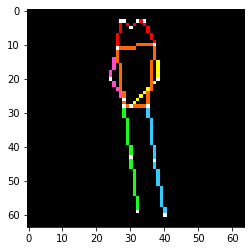

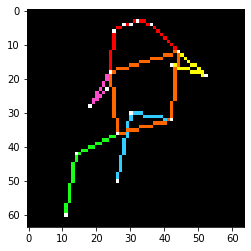

In [26]:
""" Exploring first component """
c = 5
PC = 1

scaler = StandardScaler().fit(cluster_1)
pca = PCA(n_components=PC).fit(scaler.transform(cluster_1))
X_1 = pca.transform(scaler.transform(cluster_1))
X_1_centroid = pca.transform(scaler.transform(centroid_X.reshape((1, -1)))) 
std = np.sqrt(pca.explained_variance_[PC - 1])

centroid_positive = X_1_centroid + c * std
centroid_negative = X_1_centroid - c * std

positive_dists = np.linalg.norm(X_1 - centroid_positive, axis = 1)
negative_dists = np.linalg.norm(X_1 - centroid_negative, axis = 1)

positive_closest_point = y[np.argmin(positive_dists)]
negative_closest_point = y[np.argmin(negative_dists)]

positive_kp = turn_featuremaps_to_keypoints(positive_closest_point)
negative_kp = turn_featuremaps_to_keypoints(negative_closest_point)

positive_skeleton = draw_skeleton(positive_kp)
negative_skeleton = draw_skeleton(negative_kp)

plt.imshow(positive_skeleton)
plt.show()

plt.imshow(negative_skeleton)
plt.show()

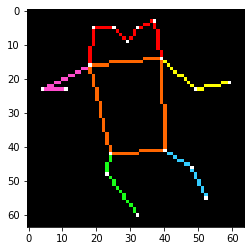

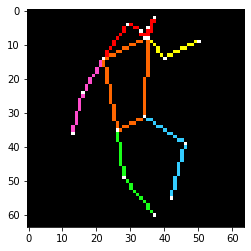

In [27]:
""" Exploring second component """
c = 5
PC = 2

scaler = StandardScaler().fit(cluster_1)
pca = PCA(n_components=PC).fit(scaler.transform(cluster_1))
X_1 = pca.transform(scaler.transform(cluster_1))
X_1_centroid = pca.transform(scaler.transform(centroid_X.reshape((1, -1)))) 
std = np.sqrt(pca.explained_variance_[PC - 1])

centroid_positive = X_1_centroid + c * std
centroid_negative = X_1_centroid - c * std

positive_dists = np.linalg.norm(X_1 - centroid_positive, axis = 1)
negative_dists = np.linalg.norm(X_1 - centroid_negative, axis = 1)

positive_closest_point = y[np.argmin(positive_dists)]
negative_closest_point = y[np.argmin(negative_dists)]

positive_kp = turn_featuremaps_to_keypoints(positive_closest_point)
negative_kp = turn_featuremaps_to_keypoints(negative_closest_point)

positive_skeleton = draw_skeleton(positive_kp)
negative_skeleton = draw_skeleton(negative_kp)

plt.imshow(positive_skeleton)
plt.show()

plt.imshow(negative_skeleton)
plt.show()

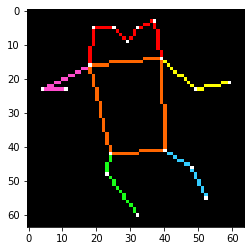

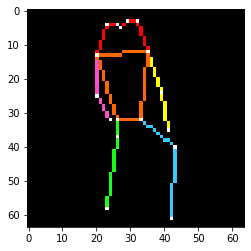

In [28]:
""" Exploring third component """
c = 5
PC = 3

scaler = StandardScaler().fit(cluster_1)
pca = PCA(n_components=PC).fit(scaler.transform(cluster_1))
X_1 = pca.transform(scaler.transform(cluster_1))
X_1_centroid = pca.transform(scaler.transform(centroid_X.reshape((1, -1)))) 
std = np.sqrt(pca.explained_variance_[PC - 1])

centroid_positive = X_1_centroid + c * std
centroid_negative = X_1_centroid - c * std

positive_dists = np.linalg.norm(X_1 - centroid_positive, axis = 1)
negative_dists = np.linalg.norm(X_1 - centroid_negative, axis = 1)

positive_closest_point = y[np.argmin(positive_dists)]
negative_closest_point = y[np.argmin(negative_dists)]

positive_kp = turn_featuremaps_to_keypoints(positive_closest_point)
negative_kp = turn_featuremaps_to_keypoints(negative_closest_point)

positive_skeleton = draw_skeleton(positive_kp)
negative_skeleton = draw_skeleton(negative_kp)

plt.imshow(positive_skeleton)
plt.show()

plt.imshow(negative_skeleton)
plt.show()

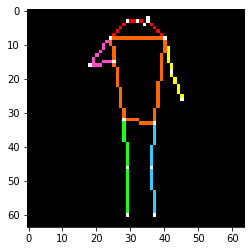

In [29]:
# Cluster 2
""" Finding centroid of data """
X_mean = np.mean(StandardScaler().fit_transform(cluster_2), axis = 0)
dists = np.linalg.norm(StandardScaler().fit_transform(cluster_2) - X_mean, axis = 1)

centroid_X = cluster_2[np.argmin(dists)]
centroid_y = y[np.argmin(dists)]

""" Visualizing centroid skeleton """
kp = turn_featuremaps_to_keypoints(centroid_y)
skeleton = draw_skeleton(kp)
plt.imshow(skeleton)
plt.show()

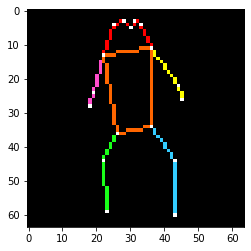

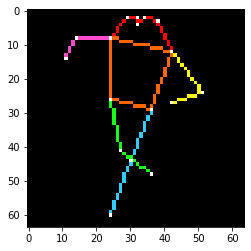

In [30]:
""" Exploring first component """
c = 5
PC = 1

scaler = StandardScaler().fit(cluster_2)
pca = PCA(n_components=PC).fit(scaler.transform(cluster_2))
X_1 = pca.transform(scaler.transform(cluster_2))
X_1_centroid = pca.transform(scaler.transform(centroid_X.reshape((1, -1)))) 
std = np.sqrt(pca.explained_variance_[PC - 1])

centroid_positive = X_1_centroid + c * std
centroid_negative = X_1_centroid - c * std

positive_dists = np.linalg.norm(X_1 - centroid_positive, axis = 1)
negative_dists = np.linalg.norm(X_1 - centroid_negative, axis = 1)

positive_closest_point = y[np.argmin(positive_dists)]
negative_closest_point = y[np.argmin(negative_dists)]

positive_kp = turn_featuremaps_to_keypoints(positive_closest_point)
negative_kp = turn_featuremaps_to_keypoints(negative_closest_point)

positive_skeleton = draw_skeleton(positive_kp)
negative_skeleton = draw_skeleton(negative_kp)

plt.imshow(positive_skeleton)
plt.show()

plt.imshow(negative_skeleton)
plt.show()

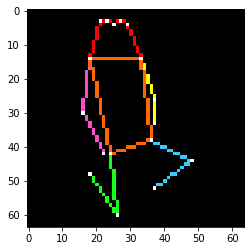

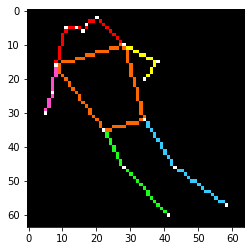

In [31]:
""" Exploring second component """
c = 5
PC = 2

scaler = StandardScaler().fit(cluster_2)
pca = PCA(n_components=PC).fit(scaler.transform(cluster_2))
X_1 = pca.transform(scaler.transform(cluster_2))
X_1_centroid = pca.transform(scaler.transform(centroid_X.reshape((1, -1)))) 
std = np.sqrt(pca.explained_variance_[PC - 1])

centroid_positive = X_1_centroid + c * std
centroid_negative = X_1_centroid - c * std

positive_dists = np.linalg.norm(X_1 - centroid_positive, axis = 1)
negative_dists = np.linalg.norm(X_1 - centroid_negative, axis = 1)

positive_closest_point = y[np.argmin(positive_dists)]
negative_closest_point = y[np.argmin(negative_dists)]

positive_kp = turn_featuremaps_to_keypoints(positive_closest_point)
negative_kp = turn_featuremaps_to_keypoints(negative_closest_point)

positive_skeleton = draw_skeleton(positive_kp)
negative_skeleton = draw_skeleton(negative_kp)

plt.imshow(positive_skeleton)
plt.show()

plt.imshow(negative_skeleton)
plt.show()

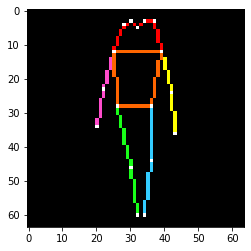

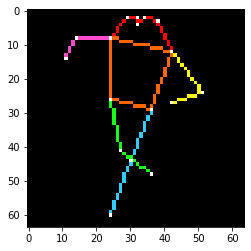

In [32]:
""" Exploring third component """
c = 5
PC = 3

scaler = StandardScaler().fit(cluster_2)
pca = PCA(n_components=PC).fit(scaler.transform(cluster_2))
X_1 = pca.transform(scaler.transform(cluster_2))
X_1_centroid = pca.transform(scaler.transform(centroid_X.reshape((1, -1)))) 
std = np.sqrt(pca.explained_variance_[PC - 1])

centroid_positive = X_1_centroid + c * std
centroid_negative = X_1_centroid - c * std

positive_dists = np.linalg.norm(X_1 - centroid_positive, axis = 1)
negative_dists = np.linalg.norm(X_1 - centroid_negative, axis = 1)

positive_closest_point = y[np.argmin(positive_dists)]
negative_closest_point = y[np.argmin(negative_dists)]

positive_kp = turn_featuremaps_to_keypoints(positive_closest_point)
negative_kp = turn_featuremaps_to_keypoints(negative_closest_point)

positive_skeleton = draw_skeleton(positive_kp)
negative_skeleton = draw_skeleton(negative_kp)

plt.imshow(positive_skeleton)
plt.show()

plt.imshow(negative_skeleton)
plt.show()